# Импорты и кастомные функции

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def make_det(df, axis, new_axis):
    df_copy = df.copy()
    for ix in list(np.unique(df.data_ind)):
        values = np.histogram(df.loc[df.data_ind == ix, axis], bins=500)
        y = values[0][3:-3]
        x = values[1][3:-4]
        p = np.polyfit(x, y, 4)
            
        poly = 0
        for coef in p:
            poly = poly*x + coef
        
        df_copy.loc[df.data_ind == ix, new_axis] = (df.loc[df.data_ind == ix, axis]
                                                    - x[np.argmax(y - poly)])
    return df_copy            

# Загрузка данных 

In [3]:
train = pd.read_csv('data/open100.csv')
test = pd.read_csv('data/test_50.csv')

In [4]:
train.head()

,id,TX,TY,X,Y,Z,signal,data_ind
0,0,-0.198782,-0.647470,29682.042969,61717.070312,2586.0,0,1
1,1,-0.022600,-0.321373,64486.812500,34733.046875,42669.0,0,1
2,2,-0.071057,-0.204883,46626.039062,30379.675781,11637.0,0,1
3,3,-0.004688,-0.167113,48441.671875,59463.445312,71115.0,0,1
4,4,-0.097321,-0.273475,49847.132812,60116.535156,53013.0,0,1


# Предварительный анализ

Посмотрим как распределены шум и сигнал вдоль координат

In [5]:
first = train.loc[train.data_ind == 1]

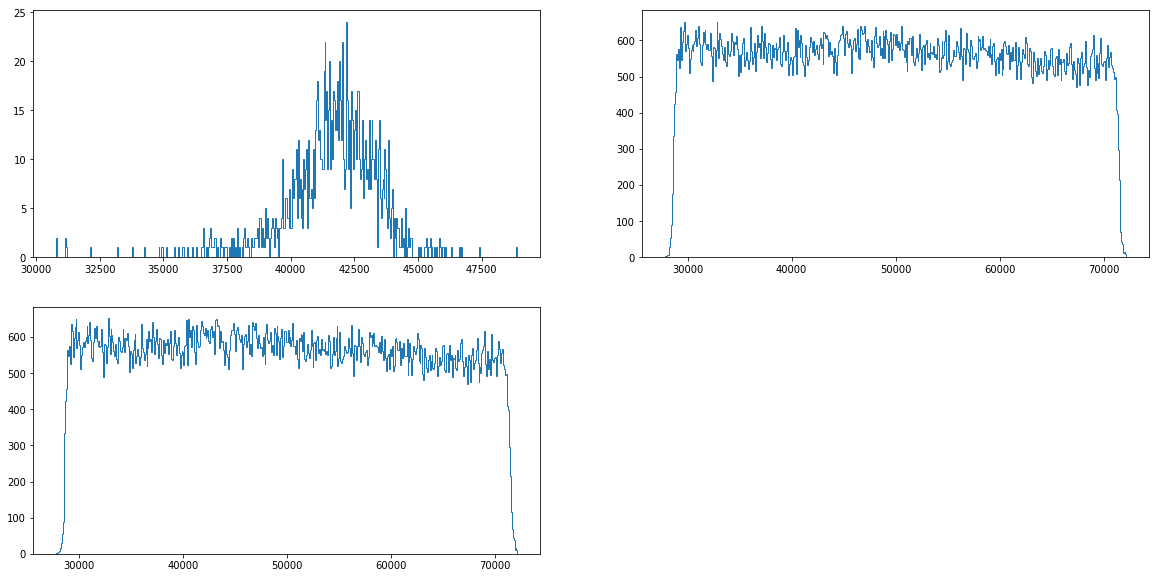

In [6]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

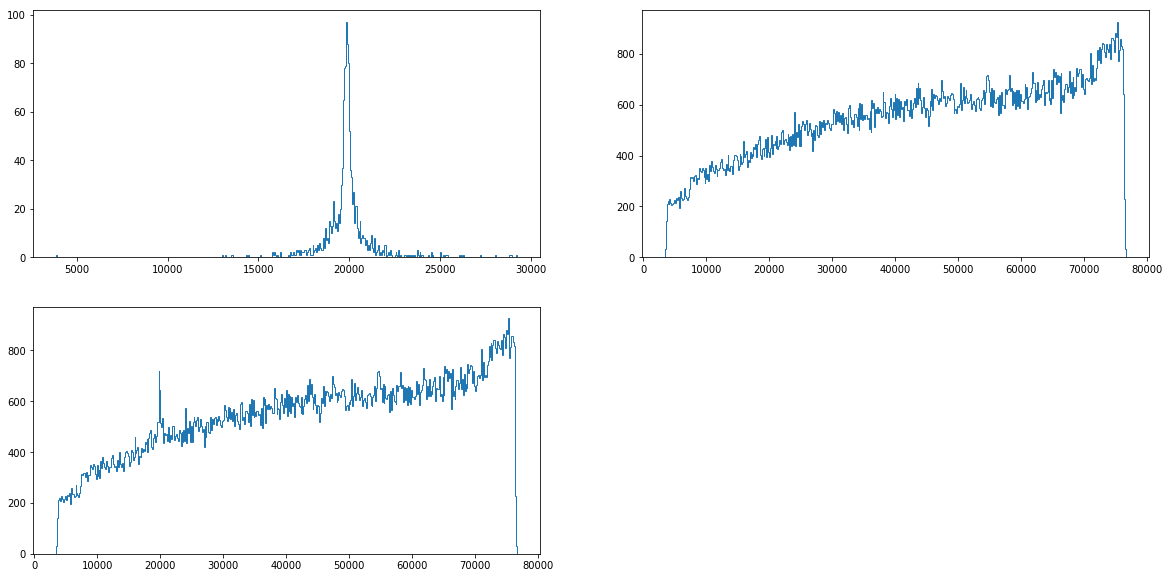

In [7]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_Y = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

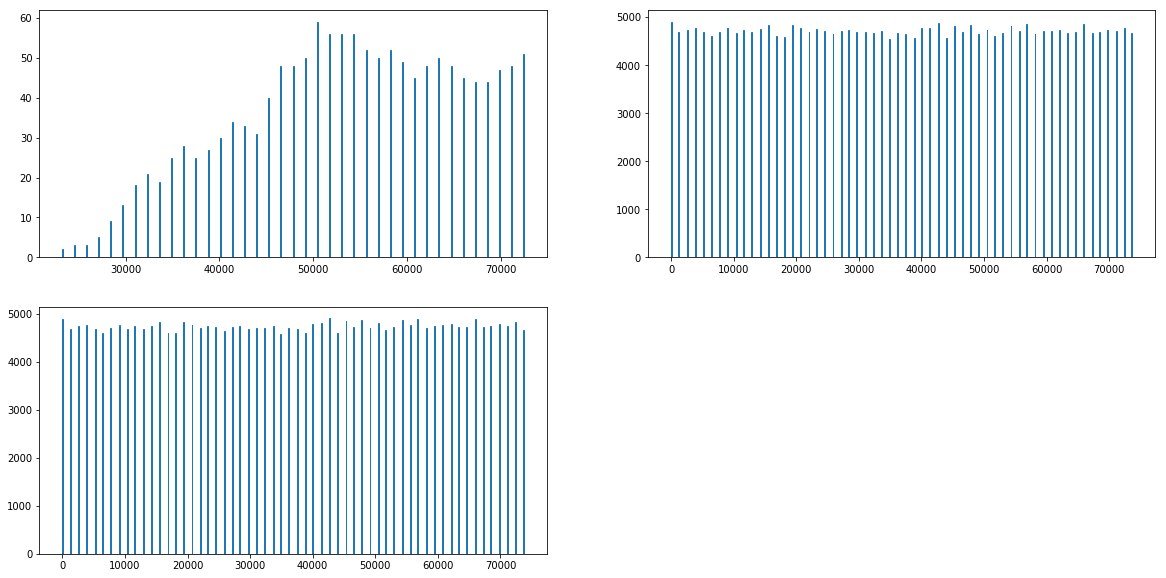

In [8]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_Z = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

Видно, что у шума есть явный тренд по осям Y и X, поэтому обучим под него какой-нибудь полином и вычтем

In [9]:
y = values_Y[0]
x = values_Y[1]
x, y = x[3:-4], y[3:-3]

In [10]:
p = np.polyfit(x, y, 4)

In [11]:
poly = 0
for coef in p:
    poly = poly*x + coef

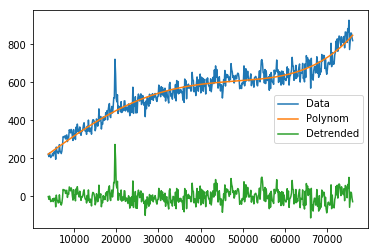

In [12]:
plt.plot(x, y, label='Data')
plt.plot(x, poly, label='Polynom')
plt.plot(x, y - poly, label='Detrended')
plt.legend()
plt.show()

Видим, что для детренженных данных очень похоже на распределение с сигналом

In [13]:
prep = train.copy()
for axis in [('X', 'detX'), ('Y', 'detY')]:
    prep = make_det(prep, axis[0], axis[1])

In [14]:
prep.head()

,id,TX,TY,X,Y,Z,signal,data_ind,detX,detY
0,0,-0.198782,-0.647470,29682.042969,61717.070312,2586.0,0,1,452.696719,42017.057530
1,1,-0.022600,-0.321373,64486.812500,34733.046875,42669.0,0,1,35257.466250,15033.034092
2,2,-0.071057,-0.204883,46626.039062,30379.675781,11637.0,0,1,17396.692813,10679.662999
3,3,-0.004688,-0.167113,48441.671875,59463.445312,71115.0,0,1,19212.325625,39763.432530
4,4,-0.097321,-0.273475,49847.132812,60116.535156,53013.0,0,1,20617.786563,40416.522374


# Обучение

In [15]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xg
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [16]:
param_grid = {
        'n_estimators':[100], 
        'max_depth':[15],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8), 
                   param_grid=param_grid, n_jobs=1,
                   scoring='roc_auc',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0))

In [17]:
y_train = prep.signal.values
X_train = prep.drop(['signal', 'id', 'data_ind'],axis=1)

In [18]:
clf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=0, shuffle=True),
       error_score='raise',
       estimator=XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
         n_estimators=100, n_jobs=1, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_depth': [15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [22]:
clf.cv_results_

C:\Users\Artyom\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Artyom\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Artyom\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Artyom\Anaconda3\lib\site-packages\sklearn\ut

{'mean_fit_time': array([1765.28243335]),
 'mean_score_time': array([98.18638372]),
 'mean_test_score': array([0.99267004]),
 'mean_train_score': array([0.99581946]),
 'param_max_depth': masked_array(data=[15],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 15, 'n_estimators': 100}],
 'rank_test_score': array([1]),
 'split0_test_score': array([0.99263637]),
 'split0_train_score': array([0.99576692]),
 'split1_test_score': array([0.99254081]),
 'split1_train_score': array([0.99583463]),
 'split2_test_score': array([0.99283294]),
 'split2_train_score': array([0.99585682]),
 'std_fit_time': array([62.29145079]),
 'std_score_time': array([4.86061043]),
 'std_test_score': array([0.00012162]),
 'std_train_score': array([3.82371072e-05])}

Вроде норм, готовим test

In [24]:
prep_test = test.copy()
for axis in [('X', 'detX'), ('Y', 'detY')]:
    prep_test = make_det(prep_test, axis[0], axis[1])

prep_test.drop(['data_ind', 'id'], axis=1, inplace=True)

In [29]:
prep_test.head()

,TX,TY,X,Y,Z,detX,detY
0,0.295499,0.099981,60690.234375,23661.033203,25860.0,31461.345875,-50377.351658
1,0.100577,0.097563,47068.710938,53209.578125,72408.0,17839.822437,-20828.806736
2,-0.121270,0.052892,30749.601562,25000.320312,62064.0,1520.713062,-49038.064549
3,0.311124,0.240402,28850.226562,60354.363281,60771.0,-378.661938,-13684.021580
4,0.498214,0.128125,42120.714844,69713.304688,12930.0,12891.826344,-4325.080174


In [33]:
probas_test = clf.predict(prep_test)

In [37]:
result = pd.DataFrame(data={'id': test.id.astype(int),
                            'signal': probas_test.astype('float16')})

In [38]:
result.head()

,id,signal
0,0,0.004230
1,1,0.005604
2,2,0.005604
3,3,0.005589
4,4,0.003357


In [39]:
result.shape

(13726164, 2)

In [40]:
result.to_csv('submit.csv', index=False)